In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!gdown --id 1MS34N0rsvWyV4gvGB1gxbGx8cjtGCvjM  

Downloading...
From: https://drive.google.com/uc?id=1MS34N0rsvWyV4gvGB1gxbGx8cjtGCvjM
To: /content/croptrainset1padding5pxl.zip
100% 730M/730M [00:03<00:00, 218MB/s]


In [ ]:
!gdown --id 1IO8tsoccsIlOCOEDAy6u4UtnCIf4EZ2F

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1IO8tsoccsIlOCOEDAy6u4UtnCIf4EZ2F 



In [ ]:
%cp -av /content/drive/MyDrive/Machima/MiniHackathon-Week1-FontRecogition/font_recognition/train/charaterset_8000 /content/

In [ ]:
!unzip --qq "/content/croptrainset2padding5pxl.zip" -d"/content/datapad/"

warning [/content/croptrainset1padding5pxl.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/croptrainset1padding5pxl.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
replace /content/datapad/cropTrainPad/10006750.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/datapad/cropTrainPad/1000bc2d.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: [y]
error:  invalid response [[y]]
replace /content/datapad/cropTrainPad/1000bc2d.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/datapad/cropTrainPad/10019de9.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
ls "/content/charaterset_8000"

Angsana_New/              FC_Knomphing_Regular/  TH_Chakra_Petch/  TH_Sarabun/
Cordia_New/               fonttintin/            TH_Charm_of_AU/
DM_Shining_Star_Regular/  Kunlasatri/            TH_Mali_Grade6/


In [ ]:
#path_data = "/content/drive/MyDrive/Machima/MiniHackathon-Week1-FontRecogition/font_recognition/train/font_fam/"
path_data = "/content/charaterset_8000/"

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
import imutils
from imutils import paths
import os
from keras import optimizers
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K

from tqdm import tqdm

%matplotlib inline

In [ ]:
def pil_image(img_path):
    pil_im =PIL.Image.open(img_path)
    #pil_im = cv2.cvtColor(pil_im, cv2.COLOR_GRAY2RGB)
    pil_im = pil_im.resize((105,105))
    #imshow(np.asarray(pil_im))

    return pil_im


# Augumentation Steps 
1) Noise
2) Blur
3) Perpective Rotation
4) Shading
5) Variable Character Spacing
6) Variable Aspect Ratio

In [ ]:
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img

In [ ]:
def blur_image(pil_im):
    #Adding Blur to image 
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

In [ ]:
def affine_rotation(img):
    
    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    #imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img
   

In [ ]:
def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian

## Preparing Dataset

In [ ]:
data_path = "/content/charaterset_8000/"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
def conv_label(label):
    if label == 'TH_Charm_of_AU':
        return 0
    elif label == 'TH_Mali_Grade6':
        return 1
    elif label == 'TH_Sarabun':
        return 2
    elif label == 'Kunlasatri':
        return 3
    elif label == 'Cordia_New':
        return 4
    elif label == 'Angsana_New':
        return 5
    elif label == 'DM_Shining_Star_Regular':
        return 6
    elif label == 'TH_Chakra_Petch':
        return 7
    elif label == 'FC_Knomphing_Regular':
        return 8
    elif label == 'fonttintin':
        return 9

In [ ]:
augument=["blur","noise"]
a=itertools.combinations(augument, 2)

for i in list(a): 
    print(list(i))

['blur', 'noise']


In [ ]:
len(imagePaths)

88090

In [ ]:
counter=0
for imagePath in imagePaths[:10000]:
    label = imagePath.split(os.path.sep)[-2]
    label = conv_label(label)
    pil_img = pil_image(imagePath)
    #imshow(pil_img)
    
    # Adding original image
    org_img = img_to_array(pil_img)
    #print(org_img.shape)
    data.append(org_img)
    labels.append(label)
    
    '''augument=["noise","blur"]
    for l in range(0,len(augument)):
    
          a=itertools.combinations(augument, l+1)

          for i in list(a): 
              combinations=list(i)
              #print(len(combinations))
              temp_img = pil_img
              for j in combinations:
            
                  if j == 'noise':
                      # Adding Noise image
                      temp_img = noise_image(temp_img)
                    
                  elif j == 'blur':
                      # Adding Blur image
                      temp_img = blur_image(temp_img)
                      #imshow(blur_img)
                    
    
                  
                  
              temp_img = img_to_array(temp_img)
              data.append(temp_img)
              labels.append(label)'''

In [ ]:
mylist = list(dict.fromkeys(labels))
#len(mylist)
mylist

[8, 6, 2, 5, 0, 4, 9, 7, 3, 1]

In [ ]:
data = np.asarray(data, dtype="float") / 255.0
labels = np.array(labels)
print("Success")
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

Success


In [ ]:
trainX.shape

(7500, 105, 105, 3)

In [ ]:

mylist = list(dict.fromkeys(trainY))
#len(mylist)
mylist

[9, 5, 3, 2, 1, 8, 7, 6, 4, 0]

In [ ]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=10)
testY = to_categorical(testY, num_classes=10)

In [ ]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

In [ ]:
#K.set_image_dim_ordering('tf')

K.set_image_data_format('channels_last')

In [ ]:
 def create_model():
  model=Sequential()

  # Cu Layers 
  model.add(Conv2D(64, kernel_size=(48, 48), activation='relu', input_shape=(105,105,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(24, 24), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2DTranspose(128, (24,24), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  model.add(Conv2DTranspose(64, (12,12), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  #Cs Layers
  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Flatten())

  model.add(Dense(4096, activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(4096,activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(2383,activation='relu'))

  model.add(Dense(10, activation='softmax'))
 
  return model

In [ ]:
import tensorflow as tf

batch_size = 128
epochs = 50
model= create_model()
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

path_s = "/content/drive/MyDrive/"
filepath= path_s + "top_model.h6"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [ ]:
model.fit(trainX, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(testX, testY),callbacks=callbacks_list)

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.1537
Epoch 00001: val_loss improved from inf to 0.08982, saving model to /content/drive/MyDrive/top_model.h6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/top_model.h6/assets
59/59 [==============================] - 61s 713ms/step - loss: 0.0900 - accuracy: 0.1537 - val_loss: 0.0898 - val_accuracy: 0.1840
Epoch 2/50
59/59 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.1907
Epoch 00002: val_loss improved from 0.08982 to 0.08955, saving model to /content/drive/MyDrive/top_model.h6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/top_model.h6/assets
59/59 [==============================] - 32s 543ms/step - loss: 0.0887 - accuracy: 0.1907 - val_loss: 0.0895 - val_accuracy: 0.1840
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.1991
Epoch 00003: val_loss improved from 0.08955 to 0.08930, saving model to /content/drive

ResourceExhaustedError: ignored

In [ ]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.027050543576478958
Test accuracy: 0.8312000036239624


In [ ]:
path_s = "/content/drive/MyDrive/"
filepath= path_s + "top_model.h5"
from keras.models import load_model
model = load_model(path_s + "top_model.h5")

In [ ]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: ignored

In [ ]:
!pwd

/content


In [ ]:
!unzip /content/drive/MyDrive/Machima/MiniHackathon-Week1-FontRecogition/Draft_submission/expandcroptest3/expandcrop3.zip

Archive:  /content/drive/MyDrive/Machima/MiniHackathon-Week1-FontRecogition/Draft_submission/expandcroptest3/expandcrop3.zip
replace content/drive/MyDrive/Machima/MiniHackathon-Week1-FontRecogition/Draft_submission/expandcroptest2/0078fafc.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
img_path="/content/cropTrainPad/1016316c.png"
pil_im =PIL.Image.open(img_path).convert('L')
pil_im = pil_im.resize((105,105))
#pil_im=blur_image(pil_im)
org_img = img_to_array(pil_im)

In [ ]:
def rev_conv_label(label):
    if label == 'TH_Charm_of_AU':
        return 0
    elif label == 'TH_Mali_Grade6':
        return 1
    elif label == 'THSarabun':
        return 2
    elif label == 'Kunlasatri':
        return 3
    elif label == 'CORDIA_New':
        return 4
    elif label == 'Angsana_New':
        return 5
    elif label == 'DM_Shining Star_Regular':
        return 6
    elif label == 'TH_Chakra_Petch':
        return 7
    elif label == 'FC_Knomphing_Regular':
        return 8
    elif label == 'fonttintin':
        return 9

In [ ]:
data=[]
data.append(org_img)
data = np.asarray(data, dtype="float") / 255.0

In [ ]:
# y = model.predict_classes(data)

y = model.predict(data)
y = np.round(y).astype(int)

In [ ]:
print(y)

[[0 0 0 1 0 0 0 0 0 0]]


In [ ]:
y

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

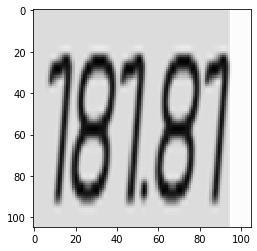

In [ ]:
label = rev_conv_label(y[0,0])
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()

In [ ]:
!mv /content/top_model.h5 /content/drive

mv: cannot create regular file '/content/drive/top_model.h5': Operation not supported


In [ ]:
path_s = "/content/"
filepath= path_s + "top_model.h5"
from keras.models import load_model
model = load_model(path_s + "top_model.h5")

In [ ]:
!gdown --id 1frXPvzbhIg9iqYDe6Ux7AuJ2WmA9DHSe  

Downloading...
From: https://drive.google.com/uc?id=1frXPvzbhIg9iqYDe6Ux7AuJ2WmA9DHSe
To: /content/testCrop.zip
100% 231M/231M [00:01<00:00, 209MB/s]


In [ ]:
!unzip /content/testCrop.zip

In [ ]:
def rev_conv_label(label):
    if label == 0:
        return 'TH_Charm_of_AU'
    elif label == 1:
        return 'TH_Mali_Grade6'
    elif label == 2:
        return 'THSarabun'
    elif label == 3:
        return 'Kunlasatri'
    elif label == 4:
        return 'CORDIA'
    elif label == 5:
        return 'Angsana_New'
    elif label == 6:
        return 'DM_Shining Star_Regular'
    elif label == 7:
        return 'TH_Chakra_Petch'
    elif label == 8:
        return 'FC_Knomphing_Regular'
    elif label == 9:
        return 'fonttintin'

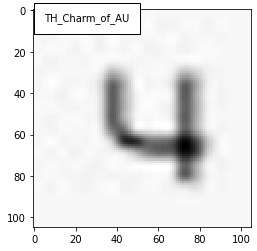

In [ ]:
label = rev_conv_label(y[0,0])
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
import imutils
from imutils import paths
import os
from keras import optimizers
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

In [ ]:
test_url = "/content/content/testCrop/"
data_test=[]
#labels_test=[]
imagePaths_test = sorted(list(paths.list_images(test_url)))

In [ ]:
import os
files = os.listdir(test_url)

In [ ]:
counter=0
for imagePath in tqdm(imagePaths_test):
  pil_im =PIL.Image.open(imagePath).convert('L')
  pil_im=pil_im.resize((105,105))
  org_img = img_to_array(pil_im)
  data_test.append(org_img)

100%|██████████| 48251/48251 [00:19<00:00, 2443.08it/s]


In [ ]:
data_test = np.asarray(data_test, dtype="float") / 255.0

In [ ]:
y = model.predict(data_test)
y = np.round(y).astype(int)

In [ ]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [ ]:
from numpy import argmax
#summed = np.sum(y, axis=0)
# argmax across classes
result5 = argmax(y, axis=1)

In [ ]:
result5

array([5, 0, 6, ..., 1, 1, 1])

In [ ]:
from tqdm import tqdm
import os
name_file = []
for root, dirs, files in tqdm(os.walk("/content/content/testCrop/")):
    for file in files:
        if file.endswith(".png"):
#              print(os.path.join(root, file))
             name_file.append(os.path.join(root, file))

1it [00:00,  4.26it/s]


In [ ]:
print(imagePaths_test)

['/content/content/testCrop/0000144b.png', '/content/content/testCrop/00013eaf.png', '/content/content/testCrop/00024a7a.png', '/content/content/testCrop/0004eae6.png', '/content/content/testCrop/00066fea.png', '/content/content/testCrop/0008d204.png', '/content/content/testCrop/0008fc86.png', '/content/content/testCrop/000aa2e3.png', '/content/content/testCrop/000af286.png', '/content/content/testCrop/000b3f13.png', '/content/content/testCrop/000f69ab.png', '/content/content/testCrop/000facb2.png', '/content/content/testCrop/0011426e.png', '/content/content/testCrop/0011b14c.png', '/content/content/testCrop/00123f98.png', '/content/content/testCrop/00126a3b.png', '/content/content/testCrop/001284ee.png', '/content/content/testCrop/0012d5c0.png', '/content/content/testCrop/00134fc6.png', '/content/content/testCrop/0013c16e.png', '/content/content/testCrop/00162600.png', '/content/content/testCrop/00168aa1.png', '/content/content/testCrop/001731b8.png', '/content/content/testCrop/0018ae

In [ ]:
import pandas as pd
result = pd.DataFrame({'nameFile': imagePaths_test})
result

,nameFile
0,/content/content/testCrop/0000144b.png
1,/content/content/testCrop/00013eaf.png
2,/content/content/testCrop/00024a7a.png
3,/content/content/testCrop/0004eae6.png
4,/content/content/testCrop/00066fea.png
...,...
48246,/content/content/testCrop/fffb9abb.png
48247,/content/content/testCrop/fffbbe56.png
48248,/content/content/testCrop/fffbcbaf.png
48249,/content/content/testCrop/fffc5245.png


In [ ]:
def remove_word(text):
  text = text.replace('/content/content/testCrop/','')
  text = text.replace('.png','')
  text = text.replace('contentcontenttestCrop','')
  return text
result['Id'] = result['nameFile'][:].apply(remove_word)
result

,nameFile,Id
0,/content/content/testCrop/0000144b.png,0000144b
1,/content/content/testCrop/00013eaf.png,00013eaf
2,/content/content/testCrop/00024a7a.png,00024a7a
3,/content/content/testCrop/0004eae6.png,0004eae6
4,/content/content/testCrop/00066fea.png,00066fea
...,...,...
48246,/content/content/testCrop/fffb9abb.png,fffb9abb
48247,/content/content/testCrop/fffbbe56.png,fffbbe56
48248,/content/content/testCrop/fffbcbaf.png,fffbcbaf
48249,/content/content/testCrop/fffc5245.png,fffc5245


In [ ]:
result['pred'] = result5

In [ ]:
result

,nameFile,Id,pred
0,/content/content/testCrop/0000144b.png,0000144b,5
1,/content/content/testCrop/00013eaf.png,00013eaf,0
2,/content/content/testCrop/00024a7a.png,00024a7a,6
3,/content/content/testCrop/0004eae6.png,0004eae6,2
4,/content/content/testCrop/00066fea.png,00066fea,3
...,...,...,...
48246,/content/content/testCrop/fffb9abb.png,fffb9abb,5
48247,/content/content/testCrop/fffbbe56.png,fffbbe56,7
48248,/content/content/testCrop/fffbcbaf.png,fffbcbaf,1
48249,/content/content/testCrop/fffc5245.png,fffc5245,1


In [ ]:
result['pred'][1]

0

In [ ]:
result['Predicted'] = result['pred'][:].apply(rev_conv_label)

Angsana_New


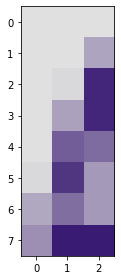

TH_Charm_of_AU


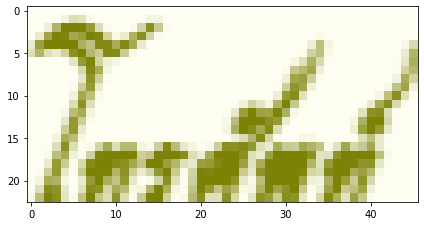

DM_Shining Star_Regular


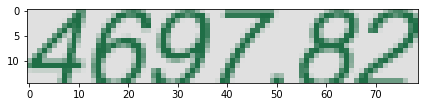

THSarabun


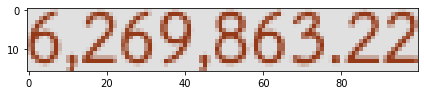

Kunlasatri


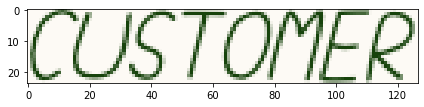

DM_Shining Star_Regular


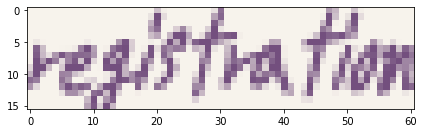

Kunlasatri


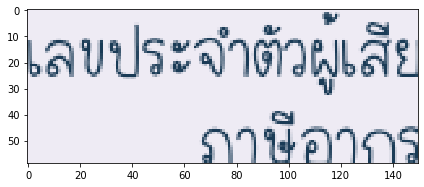

THSarabun


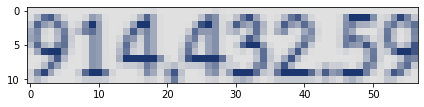

Kunlasatri


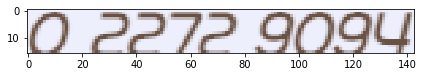

THSarabun


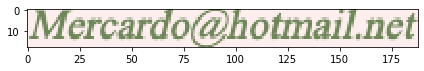

Angsana_New


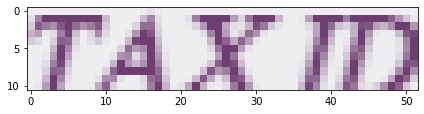

TH_Chakra_Petch


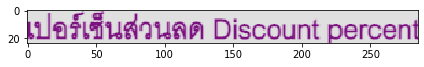

FC_Knomphing_Regular


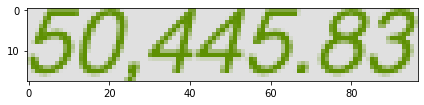

TH_Mali_Grade6


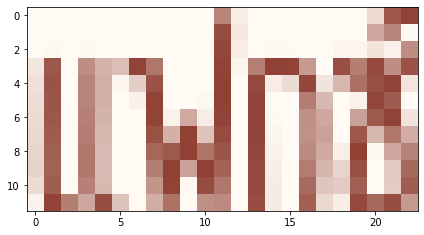

fonttintin


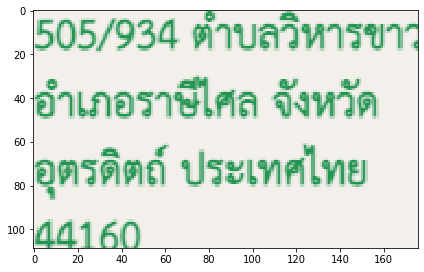

DM_Shining Star_Regular


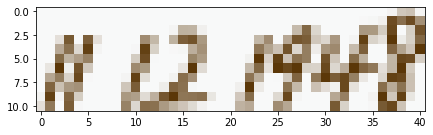

THSarabun


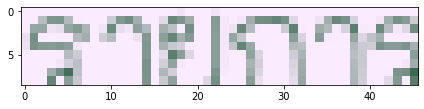

TH_Mali_Grade6


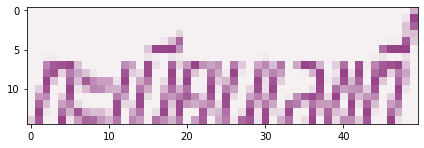

THSarabun


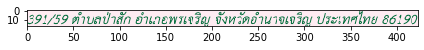

TH_Chakra_Petch


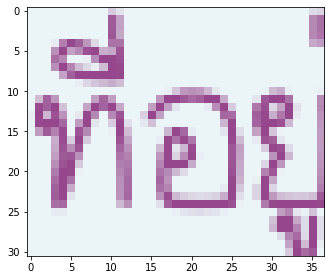

In [ ]:
from skimage import io
for i in range(20):
  #print(rev_conv_label(result['Predicted'][i]))
  print(result['Predicted'][i])
  img = io.imread(result['nameFile'][i])
  io.imshow(img)
  io.show()

In [ ]:
answer = result[["Id","Predicted"]]

In [ ]:
answer

,Id,Predicted
0,0000144b,Angsana_New
1,00013eaf,TH_Charm_of_AU
2,00024a7a,DM_Shining Star_Regular
3,0004eae6,THSarabun
4,00066fea,Kunlasatri
...,...,...
48246,fffb9abb,Angsana_New
48247,fffbbe56,TH_Chakra_Petch
48248,fffbcbaf,TH_Mali_Grade6
48249,fffc5245,TH_Mali_Grade6


In [ ]:
answer.to_csv('ToT.csv', index=False)